<a href="https://colab.research.google.com/github/kukuhagushermawan/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment03 PCD

**Nama :** Kukuh Agus Hermawan  
**NIM :** 24/533395/PA/22573  
**Kelas :** KOM


# **Image Segmentation and Morphological Processing**




## **1. Importing Library**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math
import urllib.request, io
from PIL import Image

## **2. Preprocessing**

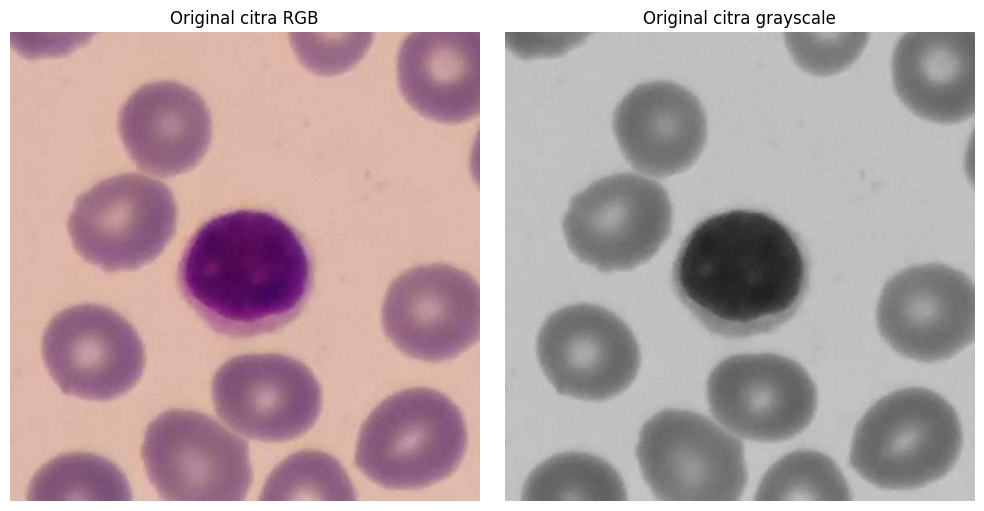

In [46]:
# input image
url = "https://raw.githubusercontent.com/kukuhagushermawan/TUGAS03_PCD/main/segmentasi_sel15.jpg"
img_bytes = io.BytesIO(urllib.request.urlopen(url).read())
rgb = np.array(Image.open(img_bytes).convert("RGB"), dtype=np.float32)

# grayscale
im = (0.299*rgb[...,0] + 0.587*rgb[...,1] + 0.114*rgb[...,2]).astype(np.uint8)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(rgb.astype(np.uint8)); plt.title("Original citra RGB"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(im, cmap='gray', vmin=0, vmax=255); plt.title("Original citra grayscale"); plt.axis('off')
plt.tight_layout(); plt.show()

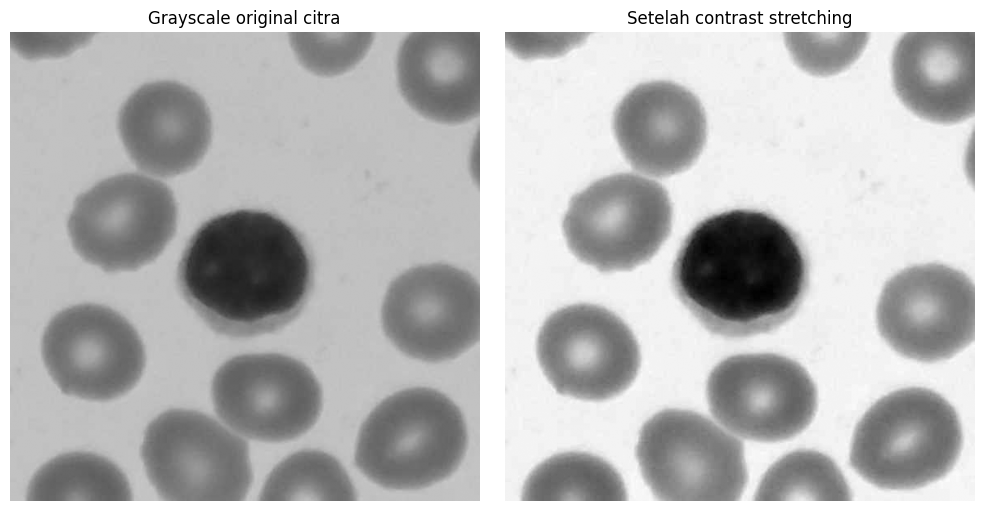

In [47]:
# sebelum melakukan segmentasi perlu perbaikan citra dengan contrast stretching

# contrast stretching
a, b = 0, 255
Imin = int(im.min())
Imax = int(im.max())

if Imax == Imin:
    im_stretch = im.copy()
else:
    im_stretch = ((im.astype(np.float32) - Imin) * ((b - a) / (Imax - Imin)) + a)
    im_stretch = np.clip(im_stretch, 0, 255).astype(np.uint8)

im_pre = im_stretch.copy()

# hasil
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(im, cmap='gray', vmin=0, vmax=255); plt.title("Grayscale original citra"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(im_stretch, cmap='gray', vmin=0, vmax=255); plt.title("Setelah contrast stretching"); plt.axis('off')
plt.tight_layout(); plt.show()


## **3. Image Segmentation**
Segmentasi citra dilakukan dengan cara melocalize/memfokuskan kepada objek yang akan dianalisis lebih lanjut.
Tujuan segmentasi citra:
1. isolasi (mendapatkan objek berupa binary image yang akan dianalisis berupa background dan foreground)
2. separasi (dapat menghasilkan lebih dari 2 kelas/banyak regionnya).

Output segemntasi dibagi menjadi 2:
1. OOI (Object Of Interest): semua objek dengan basis bentuk/shape
2. ROI (Region Of Interest): semua objek dengan basis warna/color

Metode segmentasi yang akan saya implementasikan adalah otsu method. Otsu method dilakukan dengan cara mencoba semua kemungkinan threshold dari 0-255 dan dicari treshold yang optimal dengan meminimalkan variansi dalam kelas (within-class variance).



## Otsu Method

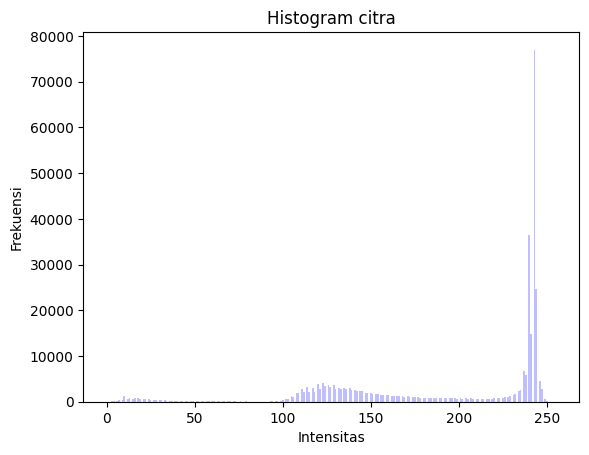

Ambang otsu (optimal threshold) = 179


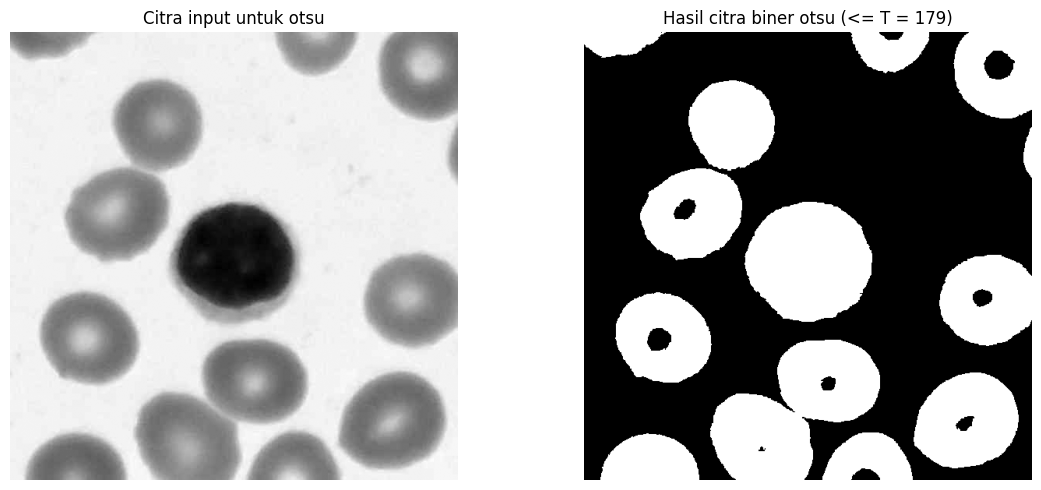

In [48]:
# IMAGE SEGMENTATION

# menyimpan nilai variansi (V2w) untuk setiap kandidat threshold
threshold_values = {}

# inisialisasi awal histogram, nanti akan diganti hasil fungsi hist()
h = [1]

# membentuk histogram dari citra grayscale hasil preproses
def Hist(img):
    row, col = img.shape
    y = np.zeros(256, dtype=np.int64)
    for i in range(row):
        for j in range(col):
            y[int(img[i, j])] += 1
    x = np.arange(0, 256)
    plt.bar(x, y, color='b', width=1.0, align='center', alpha=0.25)
    plt.title("Histogram citra")
    plt.xlabel("Intensitas")
    plt.ylabel("Frekuensi")
    plt.show()
    return y


# menghasilkan citra biner berdasarkan nilai ambang
# karena objek sel lebih gelap dari background, maka digunakan kondisi <= T
def regenerate_img(img, threshold):
    row, col = img.shape
    y = np.zeros((row, col), dtype=np.uint8)
    for i in range(row):
        for j in range(col):
            if img[i, j] <= threshold:
                y[i, j] = 255
            else:
                y[i, j] = 0
    return y


# fungsi untuk menghitung jumlah piksel, bobot, rata-rata, dan variansi tiap kelas
def countPixel(h):
    cnt = 0
    for i in range(len(h)):
        if h[i] > 0:
            cnt += h[i]
    return cnt

def wieght(s, e):
    # menghitung bobot (probabilitas) kelas berdasarkan histogram
    w = 0
    for i in range(s, e):
        w += h[i]
    return float(w)

def mean(s, e):
    # menghitung nilai rata-rata intensitas
    w = wieght(s, e)
    if w == 0:
        return 0.0
    m = 0.0
    for i in range(s, e):
        m += h[i] * i
    return m / w

def variance(s, e):
    # menghitung variansi intensitas
    w = wieght(s, e)
    if w == 0:
        return 0.0
    m = mean(s, e)
    v = 0.0
    for i in range(s, e):
        v += ((i - m) ** 2) * h[i]
    v /= w
    return v


# mencari nilai threshold optimal dengan meminimalkan within class variance (V2w)
def threshold(h_in):
    global h, threshold_values
    h = h_in.astype(float)
    threshold_values = {}

    cnt = countPixel(h)
    if cnt == 0:
        return

    L = len(h)
    for i in range(1, L):
        # kelas background (0..T)
        vb = variance(0, i)
        wb = wieght(0, i) / float(cnt)
        mb = mean(0, i)

        # kelas foreground (T..255)
        vf = variance(i, L)
        wf = wieght(i, L) / float(cnt)
        mf = mean(i, L)

        # menghitung total within class variance
        V2w = wb * vb + wf * vf

        if not math.isnan(V2w) and wb > 0 and wf > 0:
            threshold_values[i] = V2w


# menentukan nilai ambang terbaik (T) dengan mengambil V2w minimum
def get_optimal_threshold():
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
    T = int(optimal_threshold[0])
    print("Ambang otsu (optimal threshold) =", T)
    return T


# tahap segmentasi otsu
# membuat histogram citra hasil preprocess
im_pre_u8 = im_pre.astype(np.uint8)
h = Hist(im_pre_u8)

# menghitung nilai threshold optimal (berdasarkan minimum V2w)
threshold(h)
op_thres = get_optimal_threshold()

# menghasilkan citra biner dengan ambang (<= T)
res255 = regenerate_img(im_pre_u8, op_thres)
bin01  = (res255 // 255).astype(np.uint8)
bin255 = res255.copy()

# menampilkan hasil segmentasi otsu
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Citra input untuk otsu")
plt.imshow(im_pre_u8, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Hasil citra biner otsu (<= T = {op_thres})")
plt.imshow(bin255, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.tight_layout()
plt.show()


## **4. Morphological Processing**
Segmentasi menghasilkan sebuah citra binary yang terdiri dari 2 region citra yaitu foreground dan background. Terkadang hasil kualitas citra belum memisahkan region-region dengan bai. Maka dilakukan morphological processing dengan tujuan memperbaiki/meningkatkan kualitas hasil segmentasi sehingga mudah untuk dianalisis.
Simple operasi morphological terdiri dari 4:
1. Dilation: Memperbesar region dari sebuah citra objek.
2. Erosion: Memperkecil region dari sebuah citra objek
3. Opening (E + D): Meremove boundary dari pixels
4. Closing (D + E): Menutup lubang-lubang pada sebuah region

Pada penugasan kali ini saya akan mengimplementasikan keempat operasi tersebut.

## Operasi Dilation, Erosion, Opening, dan Closing
Akan digunakan structuring element dengan ukuran 3 x 3.

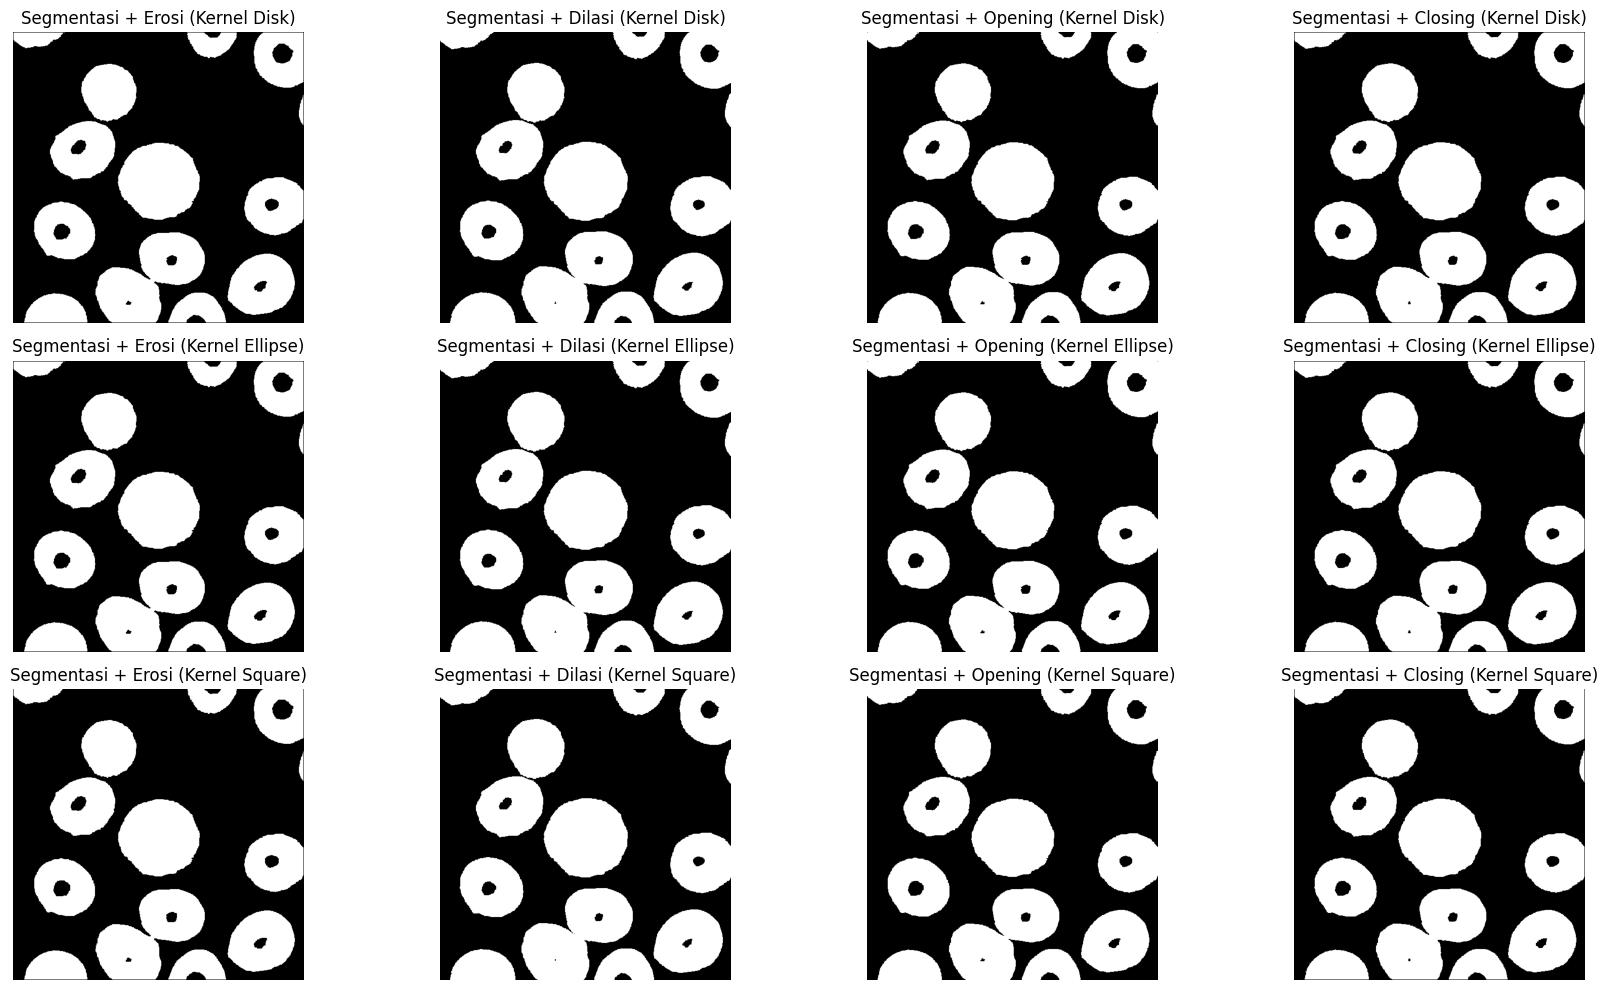

In [49]:
# MORPHOLOGICAL PROCESSING

# input citra hasil segmentasi otsu
bin01 = (im_pre_u8 <= op_thres).astype(np.uint8)
bin255 = (bin01 * 255).astype(np.uint8)

# structuring element 3×3
def se_disk(r: int) -> np.ndarray:
    yy, xx = np.ogrid[-r:r+1, -r:r+1]
    return ((xx*xx + yy*yy) <= r*r).astype(np.uint8)

def se_ellipse(h: int, w: int) -> np.ndarray:
    ry, rx = h//2, w//2
    yy, xx = np.ogrid[-ry:ry+1, -rx:rx+1]
    return ((xx*xx/((rx if rx>0 else 1)**2) + yy*yy/((ry if ry>0 else 1)**2)) <= 1).astype(np.uint8)

# tiga kernel/structuring elemen yang digunakan
SE_disk3 = se_disk(1)
SE_ell_3x3 = se_ellipse(3,3)
SE_square = np.ones((3,3), dtype=np.uint8)

# fungsi bantu padding nol
def _pad01_2d(img01, B):
    h, w = B.shape
    ry, rx = h//2, w//2
    C = np.pad(img01, ((ry, ry), (rx, rx)), mode='constant', constant_values=0)
    return C, ry, rx

# fungsi erosi: piksel bernilai 1 jika semua piksel dalam area structuring elemen juga 1
def erosion2d(img01, B):
    H, W = img01.shape
    C, ry, rx = _pad01_2d(img01, B)
    out = np.zeros_like(img01, dtype=np.uint8)
    yy, xx = np.where(B == 1)
    for i in range(H):
        for j in range(W):
            win = C[i:i+B.shape[0], j:j+B.shape[1]]
            if np.all(win[yy, xx] == 1):
                out[i, j] = 1
    return out

# fungsi dilasi: piksel bernilai 1 jika minimal ada satu piksel 1 pada area structuring elemen
def dilation2d(img01, B):
    H, W = img01.shape
    C, ry, rx = _pad01_2d(img01, B)
    out = np.zeros_like(img01, dtype=np.uint8)
    yy, xx = np.where(B == 1)
    for i in range(H):
        for j in range(W):
            win = C[i:i+B.shape[0], j:j+B.shape[1]]
            if np.any(win[yy, xx] == 1):
                out[i, j] = 1
    return out

# fungsi opening dan closing
def opening(img01, SE): return dilation2d(erosion2d(img01, SE), SE)
def closing(img01, SE): return erosion2d(dilation2d(img01, SE), SE)


# PROSES MORFOLOGI UNTUK 3 KERNEL 3 x 3
# disk
ero_disk = erosion2d(bin01, SE_disk3)
dil_disk = dilation2d(bin01, SE_disk3)
open_disk = opening(bin01, SE_disk3)
clos_disk = closing(bin01, SE_disk3)

# ellipse
ero_ell = erosion2d(bin01, SE_ell_3x3)
dil_ell = dilation2d(bin01, SE_ell_3x3)
open_ell = opening(bin01, SE_ell_3x3)
clos_ell = closing(bin01, SE_ell_3x3)

# square
ero_square = erosion2d(bin01, SE_square)
dil_square = dilation2d(bin01, SE_square)
open_square = opening(bin01, SE_square)
clos_square = closing(bin01, SE_square)


# VISUALISASI HASIL
plt.figure(figsize=(18, 10))

# disk 3×3
plt.subplot(3,4,1); plt.imshow(ero_disk*255, cmap='gray'); plt.title("Segmentasi + Erosi (Kernel Disk)"); plt.axis('off')
plt.subplot(3,4,2); plt.imshow(dil_disk*255, cmap='gray'); plt.title("Segmentasi + Dilasi (Kernel Disk)"); plt.axis('off')
plt.subplot(3,4,3); plt.imshow(open_disk*255, cmap='gray'); plt.title("Segmentasi + Opening (Kernel Disk)"); plt.axis('off')
plt.subplot(3,4,4); plt.imshow(clos_disk*255, cmap='gray'); plt.title("Segmentasi + Closing (Kernel Disk)"); plt.axis('off')

# ellipse 3×3
plt.subplot(3,4,5); plt.imshow(ero_ell*255, cmap='gray'); plt.title("Segmentasi + Erosi (Kernel Ellipse)"); plt.axis('off')
plt.subplot(3,4,6); plt.imshow(dil_ell*255, cmap='gray'); plt.title("Segmentasi + Dilasi (Kernel Ellipse)"); plt.axis('off')
plt.subplot(3,4,7); plt.imshow(open_ell*255, cmap='gray'); plt.title("Segmentasi + Opening (Kernel Ellipse)"); plt.axis('off')
plt.subplot(3,4,8); plt.imshow(clos_ell*255, cmap='gray'); plt.title("Segmentasi + Closing (Kernel Ellipse)"); plt.axis('off')

# square 3×3
plt.subplot(3,4,9);  plt.imshow(ero_square*255, cmap='gray'); plt.title("Segmentasi + Erosi (Kernel Square)"); plt.axis('off')
plt.subplot(3,4,10); plt.imshow(dil_square*255, cmap='gray'); plt.title("Segmentasi + Dilasi (Kernel Square)"); plt.axis('off')
plt.subplot(3,4,11); plt.imshow(open_square*255, cmap='gray'); plt.title("Segmentasi + Opening (Kernel Square)"); plt.axis('off')
plt.subplot(3,4,12); plt.imshow(clos_square*255, cmap='gray'); plt.title("Segmentasi + Closing (Kernel Square)"); plt.axis('off')

plt.tight_layout()
plt.show()


### Perlu diperhatikan bahwa sel belum terpisahkan dengan sempurna sehingga sistem masih sulit untuk melakukan counting, maka di sini saya memperbesar ukuran dari structuring element dan mengkombinasikan operasi morfologi.

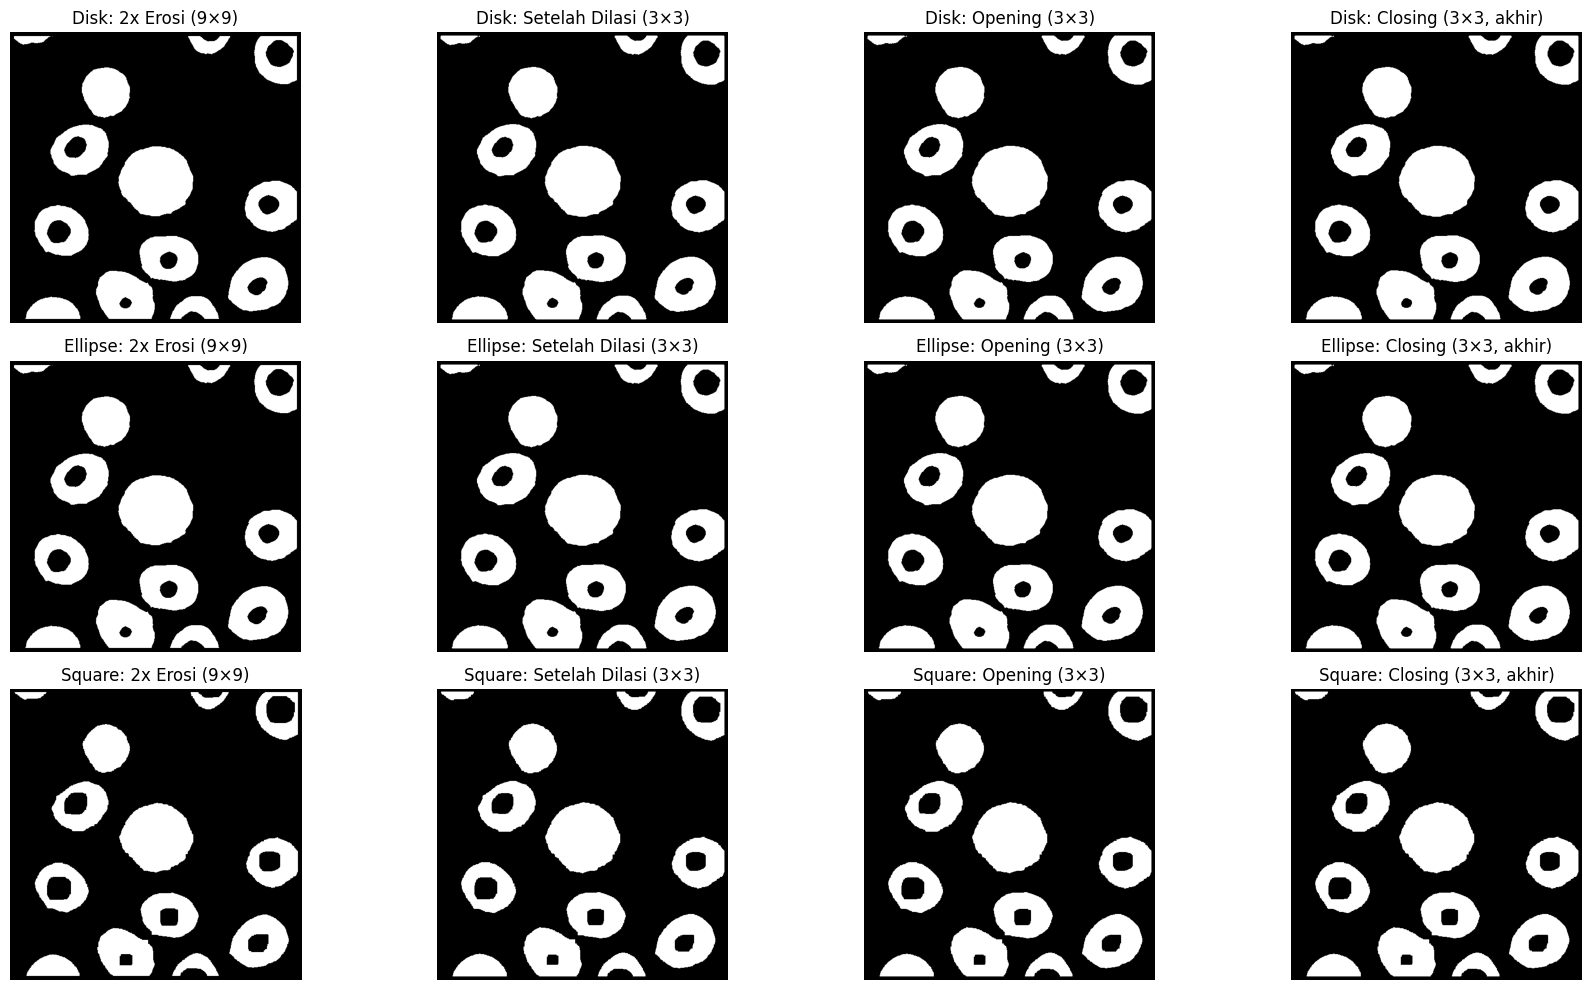

In [50]:
# KOMBINASI OPERASI MORFOLOGI

# structuring element 9x9
SE_square9 = np.ones((9,9), dtype=np.uint8)
SE_disk9 = se_disk(4)
SE_ell_9x9 = se_ellipse(9,9)

# disk
# 2x erosi dengan disk 9×9 kemudian dilasi disk 3×3 dilanjut opening disk 3×3 dan diakhiri closing square 3×3
ero_disk = erosion2d( erosion2d(bin01, SE_disk9), SE_disk9 )
dil_disk = dilation2d(ero_disk, SE_disk3)
open_disk = opening(dil_disk, SE_disk3)
clos_disk = closing(open_disk, SE_square)

# ellipse
# 2x erosi dengan ellipse 9×9 kemudian dilasi ellipse 3×3 dilanjut opening ellipse 3×3 dan diakhiri closing ellipse 3×3
ero_ell = erosion2d( erosion2d(bin01, SE_ell_9x9), SE_ell_9x9 )
dil_ell = dilation2d(ero_ell, SE_ell_3x3)
open_ell = opening(dil_ell, SE_ell_3x3)
clos_ell = closing(open_ell, SE_ell_3x3)

# square
# 2x erosi dengan square 9×9 kemudian dilasi square 3×3 dilanjut opening square 3×3 dan diakhiri closing square 3×3
ero_square = erosion2d( erosion2d(bin01, SE_square9), SE_square9 )
dil_square = dilation2d(ero_square, SE_square)
open_square = opening(dil_square, SE_square)
clos_square = closing(open_square, SE_square)

# hasil
plt.figure(figsize=(18, 10))

# disk
plt.subplot(3,4,1); plt.imshow(ero_disk*255, cmap='gray')
plt.title("Disk: 2x Erosi (9×9)"); plt.axis('off')

plt.subplot(3,4,2); plt.imshow(dil_disk*255, cmap='gray')
plt.title("Disk: Setelah Dilasi (3×3)"); plt.axis('off')

plt.subplot(3,4,3); plt.imshow(open_disk*255, cmap='gray')
plt.title("Disk: Opening (3×3)"); plt.axis('off')

plt.subplot(3,4,4); plt.imshow(clos_disk*255, cmap='gray')
plt.title("Disk: Closing (3×3, akhir)"); plt.axis('off')


# ellipse
plt.subplot(3,4,5); plt.imshow(ero_ell*255, cmap='gray')
plt.title("Ellipse: 2x Erosi (9×9)"); plt.axis('off')

plt.subplot(3,4,6); plt.imshow(dil_ell*255, cmap='gray')
plt.title("Ellipse: Setelah Dilasi (3×3)"); plt.axis('off')

plt.subplot(3,4,7); plt.imshow(open_ell*255, cmap='gray')
plt.title("Ellipse: Opening (3×3)"); plt.axis('off')

plt.subplot(3,4,8); plt.imshow(clos_ell*255, cmap='gray')
plt.title("Ellipse: Closing (3×3, akhir)"); plt.axis('off')


# square
plt.subplot(3,4,9); plt.imshow(ero_square*255, cmap='gray')
plt.title("Square: 2x Erosi (9×9)"); plt.axis('off')

plt.subplot(3,4,10); plt.imshow(dil_square*255, cmap='gray')
plt.title("Square: Setelah Dilasi (3×3)"); plt.axis('off')

plt.subplot(3,4,11); plt.imshow(open_square*255, cmap='gray')
plt.title("Square: Opening (3×3)"); plt.axis('off')

plt.subplot(3,4,12); plt.imshow(clos_square*255, cmap='gray')
plt.title("Square: Closing (3×3, akhir)"); plt.axis('off')

plt.tight_layout()
plt.show()


## **5. Analisis Hasil**

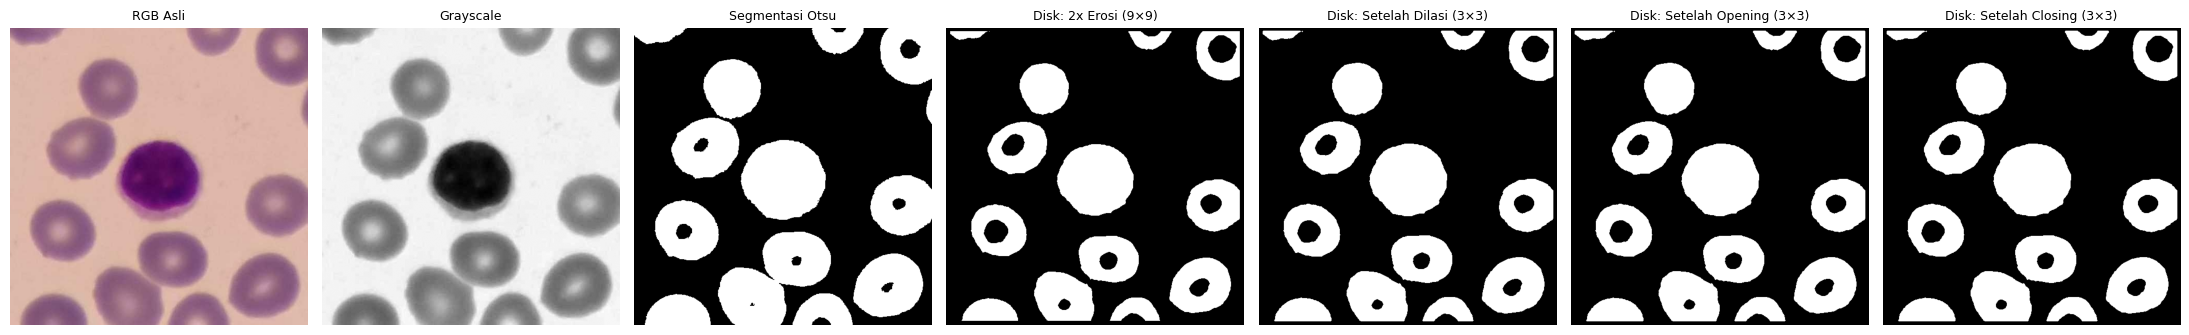

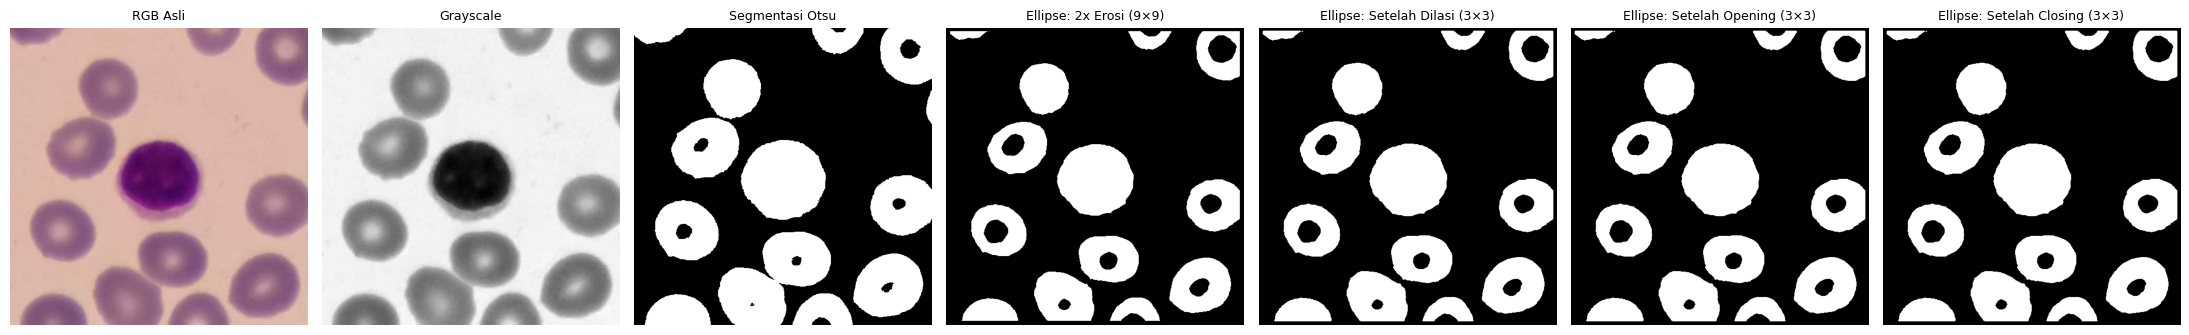

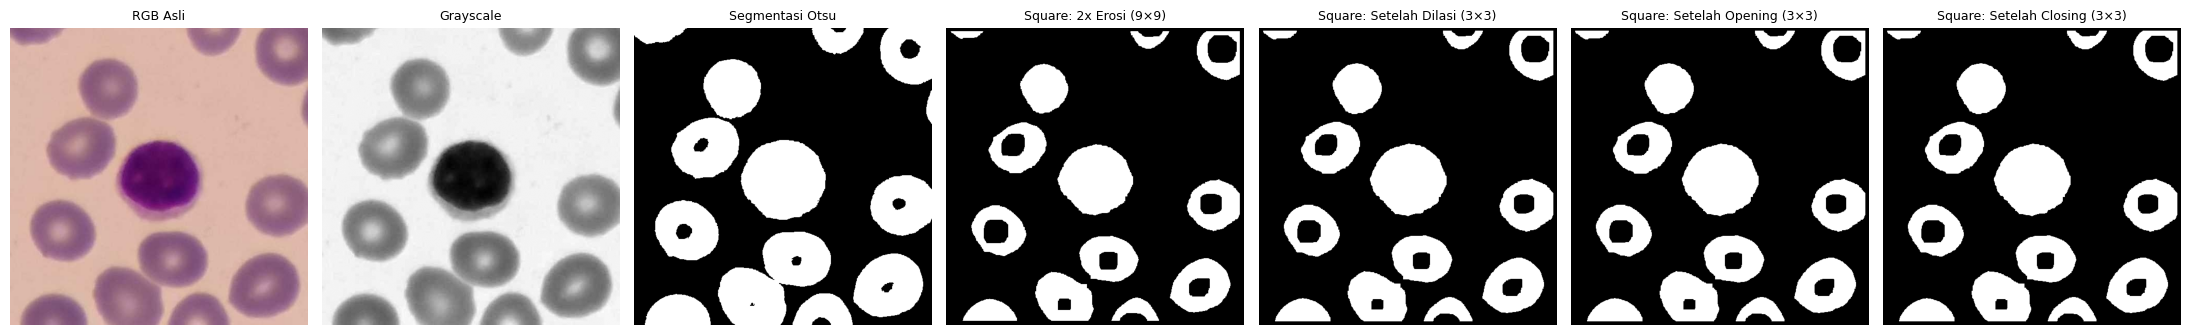

In [51]:
# fungsi comparison
def show_comparison(images, titles, figsize=(22,4)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        if img.ndim == 3:
            plt.imshow(img.astype(np.uint8))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

img_rgb   = rgb.astype(np.uint8)
img_gray  = im_pre_u8
img_otsu  = bin255

# baris 1: kernel disk (kombinasi 2x erosi dengan disk 9×9 kemudian dilasi disk 3×3 dilanjut opening disk 3×3 dan diakhiri closing square 3×3)
show_comparison(
    [
        img_rgb,
        img_gray,
        img_otsu,
        ero_disk * 255,
        dil_disk * 255,
        open_disk * 255,
        clos_disk * 255
    ],
    [
        "RGB Asli",
        "Grayscale",
        "Segmentasi Otsu",
        "Disk: 2x Erosi (9×9)",
        "Disk: Setelah Dilasi (3×3)",
        "Disk: Setelah Opening (3×3)",
        "Disk: Setelah Closing (3×3)"
    ]
)

# baris 2: kernel ellipse (kombinasi 2x erosi dengan ellipse 9×9 kemudian dilasi ellipse 3×3 dilanjut opening ellipse 3×3 dan diakhiri closing ellipse 3×3)
show_comparison(
    [
        img_rgb,
        img_gray,
        img_otsu,
        ero_ell * 255,
        dil_ell * 255,
        open_ell * 255,
        clos_ell * 255
    ],
    [
        "RGB Asli",
        "Grayscale",
        "Segmentasi Otsu",
        "Ellipse: 2x Erosi (9×9)",
        "Ellipse: Setelah Dilasi (3×3)",
        "Ellipse: Setelah Opening (3×3)",
        "Ellipse: Setelah Closing (3×3)"
    ]
)

# baris 3: kernel square (kombinasi 2x erosi dengan square 9×9 kemudian dilasi square 3×3 dilanjut opening square 3×3 dan diakhiri closing square 3×3)
show_comparison(
    [
        img_rgb,
        img_gray,
        img_otsu,
        ero_square * 255,
        dil_square * 255,
        open_square * 255,
        clos_square * 255
    ],
    [
        "RGB Asli",
        "Grayscale",
        "Segmentasi Otsu",
        "Square: 2x Erosi (9×9)",
        "Square: Setelah Dilasi (3×3)",
        "Square: Setelah Opening (3×3)",
        "Square: Setelah Closing (3×3)"
    ]
)


### **1. Perbandingan Hasil Segmentasi dengan Segmentasi yang Dilanjut Morphological Processing**

Pada hasil segmentasi dengan otsu method, citra memang berhasil memisahkan objek utama (sel darah merah) dari backgroundnya berdasarkan intensitas piksel. Tetapi, hasilnya masih belum sempurna karena beberapa sel taerlihat saling menempel dan tepi sel masih terlihat kasar. Selain itu masih terdapat noise kecil di sekitar background yang membuat hasil segmentasi kurang bersih. Setelah ditambahkan morphological processing, citra menjadi lebih halus dan tepi selnya juga jelas. Proses morfologi membantu memperjelas bentuk tiap sel, memisahkan sel yang saling menempel, serta menutup bagian yang berlubang/filling the hole. Dengan demikian, hasil segmentasi setelah ditambah proses morfologi tidak hanya memisahkan objek dari background, tetapi juga memperbaiki bentuk sel, merapikan tepi, dan meningkatkan kualitas citra.


### **2. Analisis Operasi Morfologi (Erosi, Dilasi, Opening, dan Closing)**

Operasi erosi (memperkecil region sebuah citra) pada konteks ini bekerja dengan mengikis bagian tepi objek sehingga ukuran sel menjadi lebih kecil dan sel yang menempel dapat terpisah. Erosi dua kali dengan kernel (9×9) bisa memisahkan antar sel, namun efeknya adalah hilangnya sebagian detail halus di tepi objek. Pada percobaan ini saya juga sudah menerapkan erosi 3x3 dan 7x7 akan tetapi ada beberapa sel yang masih menempel sehingga saya perbesar untuk structuring elemennya. Setelah itu ada operasi dilasi (memperbesar region sebuah citra) dilakukan untuk memperluas kembali area objek yang sebelumnya terkikis oleh erosi. Proses ini membantu mengembalikan bentuk sel seperti dengan yang aslinya, serta memperhalus batas antar sel. Selanjutnya, operasi opening yang merupakan kombinasi erosi dan dilasi, digunakan untuk menghilangkan noise kecil di background tanpa mengubah bentuk utama sel. Terakhir, operasi closing (dilasi lalu erosi) berfungsi menutup lubang-lubang kecil/filling the hole di dalam sel sehingga bagian tengahnya terlihat lebih padat. Secara keseluruhan, urutan operasi ini membuat citra lebih bersih dan mudah dianalisis.


### **3. Perbandingan Penggunaan Kernel (Disk, Ellipse, dan Square)**

Hasil operasi morfologi berbeda tergantung pada bentuk kernel yang digunakan. kernel disk menghasilkan hasil terbaik dan paling natural karena bentuknya menyerupai sel darah merah. Kontur sel tampak halus, tepi tidak pecah, dan bagian tengah tetap terlihat jelas. Kernel ellipse memberikan hasil serupa, namun karena bentuknya sedikit lonjong, hasil citra tampak sedikit tertekan di salah satu arah. Sementara itu, kernel square memberikan hasil yang lebih kaku karena bentuknya bersudut tajam. Meskipun tetap mampu membersihkan noise dan memisahkan objek dengan baik, tepi sel terlihat tidak sehalus pada kernel disk atau ellipse.


### **4. Kesimpulan**

Dari keseluruhan proses dapat disimpulkan bahwa kombinasi segmentasi otsu dan morphological processing memberikan hasil yang jauh lebih baik dibanding segmentasi saja. Setiap operasi morfologi memiliki fungsi penting dalam memperbaiki struktur objek, mulai dari memisahkan sel, menghaluskan tepi, hingga menutup lubang kecil/filling the hole di area dalam sel. Berdasarkan perbandingan kernel, bentuk disk merupakan yang paling optimal karena menghasilkan citra yang halus, natural, dan menyerupai bentuk asli sel darah merah. Kernel ellipse memberikan hasil yang masih baik, sementara kernel square kurang tepat untuk objek berbentuk melingkar. Secara keseluruhan proses ini menunjukkan bahwa pemilihan bentuk kernel dan urutan operasi sangat berpengaruh terhadap kualitas hasil akhir dari sebuah citra
